In [1]:
import json
import pandas as pd
import os
import shutil
from glob import glob
import zipfile
import numpy as np
from tqdm import tqdm
from shapely import wkb
from shapely.geometry import shape
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
QV_THRESHOLD = 20 

In [36]:
class_list = {
    0: "Tumor epithelial",
    1: "Non-tumor epithelial",
    2: "Basal/Myoepithelial",
    3: "Smooth muscle",
    4: "Fibroblast",
    5: "Endothelial",
    6: "Lymphocyte",                # T + B 통합
    7: "Plasma cell",
    8: "Macrophage/Histiocyte",     # 통합
    9: "Neutrophil",
    10: "Adipocyte",
    11: "Other/Unknown"
}
marker_genes = {
    "Tumor epithelial": [
        b"EPCAM", b"KRT5", b"KRT14", b"KRT23",
        b"ERBB2", b"MKI67", b"GATA3", b"KRT6B",
        b"CEACAM6", b"CCND1", b"TFAP2A", b"ANKRD30A",
        b"CEACAM8", b"CXCL5"
    ],

    "Non-tumor epithelial": [
        b"EPCAM", b"KRT8", b"CDH1", b"KRT7",
        b"DSP", b"MUC6", b"JUP", b"SCGB2A1"
    ],

    "Basal/Myoepithelial": [
        b"KRT5", b"KRT14", b"ACTA2"
    ],

    "Smooth muscle": [
        b"MYH11", b"ACTA2", b"MYLK"
    ],

    "Fibroblast": [
        b"PDGFRA", b"PDGFRB", b"DPT", b"LUM",
        b"SFRP1", b"FBLN1", b"SFRP4", b"POSTN"
    ],

    "Endothelial": [
        b"PECAM1", b"KDR", b"CD93", b"EGFL7",
        b"VWF", b"CLEC14A", b"MMRN2", b"ESM1"
    ],

    "Lymphocyte": [  # T + B 통합
        b"CD3E", b"CD3G",
        b"GZMA", b"GZMK", b"NKG7", b"CCL5",
        b"TRAC", b"TCF7", b"LTB", b"IL2RG",
        b"CD4", b"CD8A",
        b"CD79A", b"CD79B", b"MS4A1", b"CD19",
        b"CD69", b"CXCR4", b"CCR7", b"SELL"
    ],

    "Plasma cell": [
        b"MZB1", b"PRDM1", b"TNFRSF17", b"SLAMF7"
    ],

    "Macrophage/Histiocyte": [
        b"CD68", b"CD163", b"MRC1", b"C1QA",
        b"AIF1", b"CD14", b"FCGR3A", b"CX3CR1"
    ],

    "Neutrophil": [
        b"S100A8", b"LYZ", b"CEACAM8", b"MMP12"
    ],

    "Adipocyte": [
        b"ADIPOQ", b"LPL", b"PPARG"
    ],

    "Other/Unknown": []
}

class_colors_hex = {
    "Tumor epithelial": "#FF0000",        # 빨강
    "Non-tumor epithelial": "#FFB6C1",    # 연분홍
    "Basal/Myoepithelial": "#FFA500",     # 주황
    "Smooth muscle": "#8B4513",           # 갈색
    "Fibroblast": "#00FF00",              # 초록
    "Endothelial": "#0000FF",             # 파랑
    "Lymphocyte": "#FFFF00",              # 노랑 (T/B lymphocyte 통합)
    "Plasma cell": "#9400D3",             # 보라
    "Macrophage/Histiocyte": "#00FFFF",   # 시안(청록)
    "Neutrophil": "#1E90FF",              # DodgerBlue (밝은 파랑)
    "Adipocyte": "#FFC0CB",               # 핑크
    "Other/Unknown": "#808080"            # 회색
}
class_colors = {
    "Tumor epithelial": [255, 0, 0],            # 빨강 - 종양 상피
    "Non-tumor epithelial": [255, 182, 193],    # 연분홍 - 정상 상피
    "Basal/Myoepithelial": [255, 165, 0],       # 주황
    "Smooth muscle": [139, 69, 19],             # 갈색
    "Fibroblast": [0, 255, 0],                  # 초록
    "Endothelial": [0, 0, 255],                 # 파랑
    "Lymphocyte": [255, 255, 0],                # 노랑 (T/B 통합)
    "Plasma cell": [148, 0, 211],               # 보라
    "Macrophage/Histiocyte": [0, 255, 255],     # 시안 (청록)
    "Neutrophil": [30, 144, 255],               # 도저블루 (밝은 파랑)
    "Adipocyte": [255, 192, 203],               # 핑크
    "Other/Unknown": [128, 128, 128]            # 회색
}


In [5]:
xenium_annotation_list=glob('../../data/Brest_spatialTranscriptome/xenium_seg/*_xenium_nucleus_seg.parquet')
xenium_wsi_list = [f.replace("xenium_seg/", "wsis/") for f in xenium_annotation_list]
xenium_wsi_list = [f.replace("_xenium_nucleus_seg.parquet", ".tif") for f in xenium_wsi_list]
xenium_metadata_list = [f.replace("wsis/", "metadata/") for f in xenium_wsi_list]
xenium_metadata_list = [f.replace(".tif", ".json") for f in xenium_metadata_list]
xenium_patche_list = [f.replace("wsis/", "patches/") for f in xenium_wsi_list]
xenium_patche_list = [f.replace(".tif", ".h5") for f in xenium_patche_list]
save_path='../../data/Brest_spatialTranscriptome/preprocessed_xenium/'
for i in tqdm(range(len(xenium_annotation_list))):
    zip_path = xenium_annotation_list[i]
    wsi_path = xenium_wsi_list[i]
    create_dir(save_path+'wsis/')
    create_dir(save_path+'metadata/')
    create_dir(save_path+'patches/')
    shutil.copy(wsi_path, f'{save_path}wsis/{os.path.basename(wsi_path)}')
    shutil.copy(xenium_metadata_list[i], f'{save_path}metadata/{os.path.basename(xenium_metadata_list[i])}')
    shutil.copy(xenium_patche_list[i], f'{save_path}patches/{os.path.basename(xenium_patche_list[i])}')

100%|██████████| 9/9 [03:44<00:00, 24.92s/it]


In [6]:

def classify_cell_by_genes(gene_list, marker_dict):
    """여러 유전자를 기반으로 cell type scoring"""
    scores = {cell_type: 0 for cell_type in marker_dict.keys()}
    
    for gene in gene_list:
        for cell_type, markers in marker_dict.items():
            if gene in markers:
                scores[cell_type] += 1
    
    # 가장 높은 점수의 cell type 반환
    max_score = max(scores.values())
    if max_score == 0:
        return 'Other/Unknown', 0
    
    best_type = max(scores, key=scores.get)
    return best_type, scores
save_path='../../data/Brest_spatialTranscriptome/preprocessed_xenium/'
xenium_transcripts_list=[f.replace("xenium_seg/", "transcripts/") for f in xenium_annotation_list]
xenium_transcripts_list=[f.replace("_xenium_nucleus_seg.parquet", "_transcripts.parquet") for f in xenium_transcripts_list]
for i in range(len(xenium_transcripts_list)):
    xenium_transcript_path = xenium_transcripts_list[i]
    df_transcript = pd.read_parquet(xenium_transcript_path)
    df_filtered = df_transcript[df_transcript['qv'] > QV_THRESHOLD].copy()
    
    df_filtered = df_filtered[~df_filtered['feature_name'].str.decode('utf-8').str.contains('BLANK|NegControl|antisense', case=False, na=False)]
    xenium_annotation_path=xenium_annotation_list[i]
    df_seg = pd.read_parquet(xenium_annotation_path)
    df=pd.DataFrame(columns=['x1','y1','x2','y2','class_name'])
    annotations = []
    grouped_transcripts = df_filtered.groupby('cell_id')['feature_name'].apply(list).to_dict()
    for j in tqdm(range(len(df_seg))):
        temp_df_seg=df_seg.iloc[j]
        cell_id=temp_df_seg.name
        geom_binary=temp_df_seg['geometry']
        polygon = wkb.loads(geom_binary)
        x,y=polygon.exterior.xy
        x1=int(np.min(x))
        y1=int(np.min(y))
        x2=int(np.max(x))
        y2=int(np.max(y))
        try:
            genes_in_cell=grouped_transcripts[cell_id]
            cell_type, score = classify_cell_by_genes(genes_in_cell, marker_genes)
            annotations.append({
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'class_name': cell_type,
            })
        except KeyError:
            continue
    df = pd.DataFrame(annotations)
    create_dir(save_path+'labels/')    
    df.to_csv(save_path+'labels/'+os.path.basename(xenium_annotation_path).replace('_xenium_nucleus_seg.parquet', '.csv'), index=False)

100%|██████████| 142272/142272 [00:37<00:00, 3833.86it/s]

100%|██████████| 118752/118752 [00:52<00:00, 2247.65it/s]

100%|██████████| 167780/167780 [01:13<00:00, 2268.83it/s]

100%|██████████| 356746/356746 [01:40<00:00, 3545.71it/s]

100%|██████████| 574852/574852 [02:59<00:00, 3201.32it/s]

100%|██████████| 365604/365604 [01:55<00:00, 3165.95it/s]

100%|██████████| 574527/574527 [03:20<00:00, 2870.58it/s]

100%|██████████| 885523/885523 [04:28<00:00, 3297.70it/s]

100%|██████████| 892966/892966 [04:36<00:00, 3232.30it/s]



In [34]:
label_list=glob('../../data/Brest_spatialTranscriptome/preprocessed_xenium/labels/*.csv')

for i in range(len(label_list)):
    label_df=pd.read_csv(label_list[i])
    label_df['class_name'] = label_df['class_name'].str.replace("b'", "", regex=False).str.replace("'", "", regex=False)
    label_df.to_csv(label_list[i], index=False)

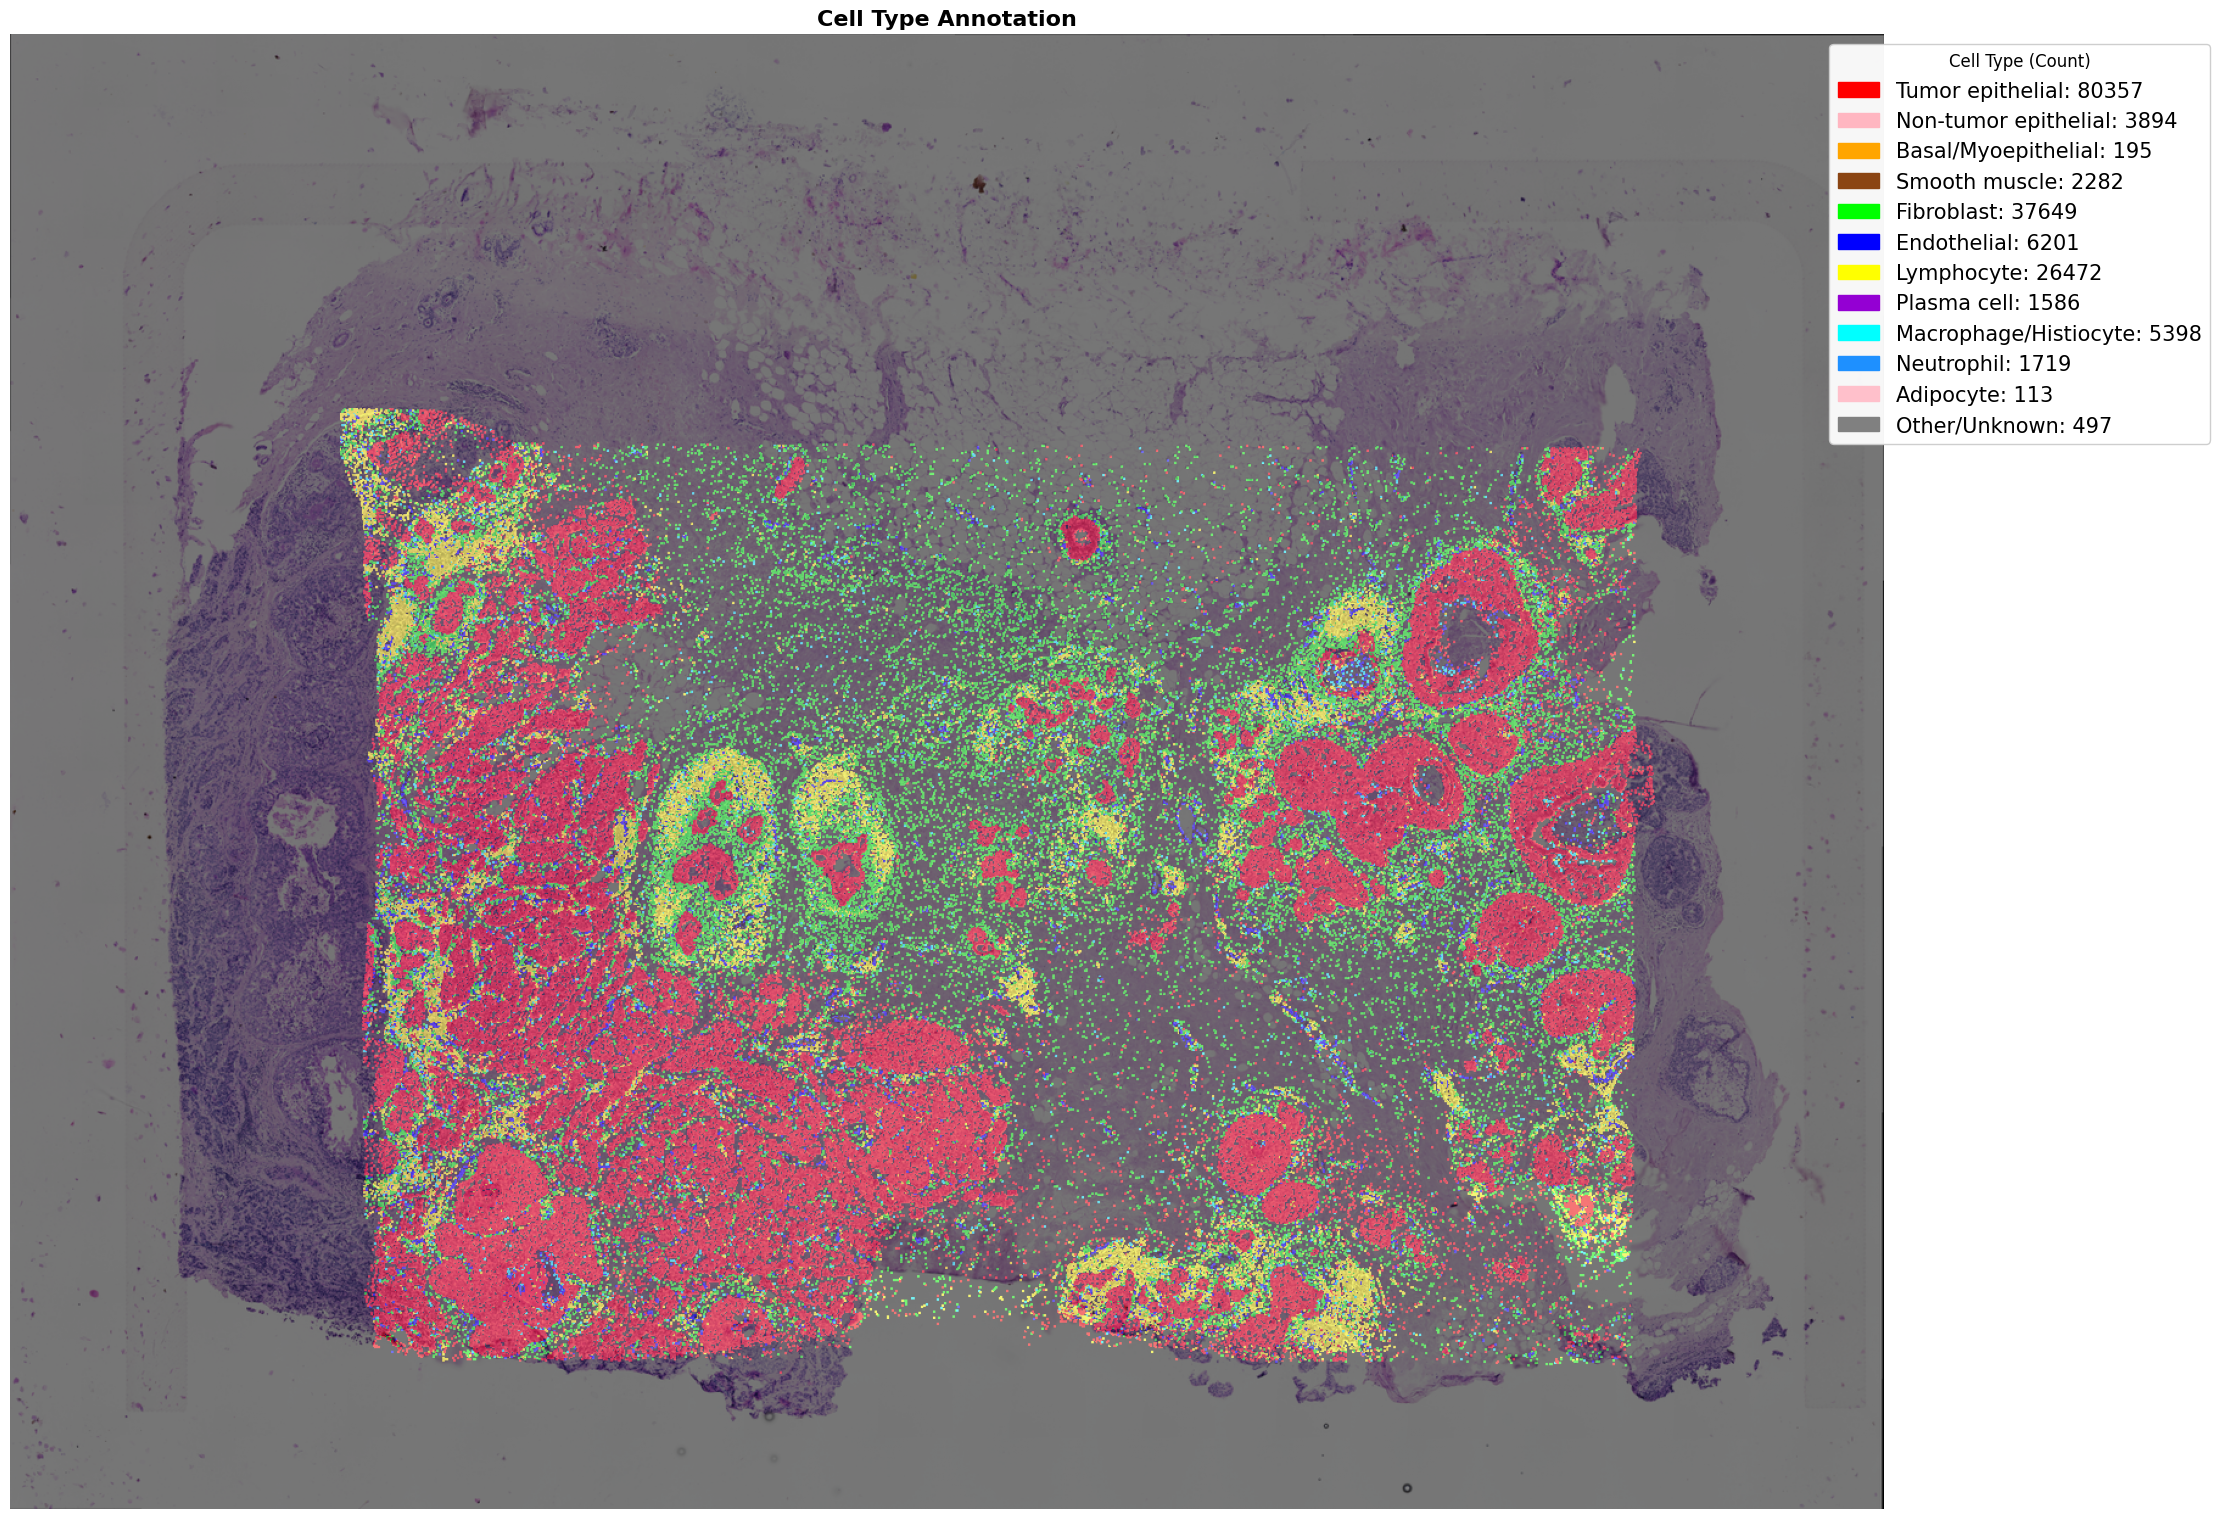

=== Cell Type Statistics ===
Total cells: 166363

Cell type distribution:
class_name
Adipocyte                  113
Basal/Myoepithelial        195
Endothelial               6201
Fibroblast               37649
Lymphocyte               26472
Macrophage/Histiocyte     5398
Neutrophil                1719
Non-tumor epithelial      3894
Other/Unknown              497
Plasma cell               1586
Smooth muscle             2282
Tumor epithelial         80357
Name: count, dtype: int64


In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import openslide as ops

reduction_factor=20
slide=ops.OpenSlide('../../data/Brest_spatialTranscriptome/preprocessed_xenium/wsis/NCBI785.tif')
thumbnail = slide.get_thumbnail((slide.level_dimensions[0][0] // reduction_factor, slide.level_dimensions[0][1] // reduction_factor))
mask=np.ones_like(np.array(thumbnail)) * 0
labels_df=pd.read_csv('../../data/Brest_spatialTranscriptome/preprocessed_xenium/labels/NCBI785.csv')

fig, ax = plt.subplots(figsize=(22, 20))

for idx, row in labels_df.iterrows():
    x=row['x1']/reduction_factor + row['x2']/reduction_factor
    x=x//2
    y=row['y1']/reduction_factor + row['y2']/reduction_factor
    y=y//2
    mask[int(y):int(y)+2, int(x):int(x)+2]=np.array(class_colors[row['class_name']])/255.

ax.imshow(mask*0.5 + np.array(thumbnail)/255.*0.5)
ax.axis('off')
ax.set_title('Cell Type Annotation', fontsize=16, fontweight='bold')

# 클래스별 개수 계산
class_counts = labels_df['class_name'].value_counts()

# 범례 추가 (클래스 개수 포함)
legend_patches = []
for class_name, hex_color in class_colors_hex.items():
    count = class_counts.get(class_name, 0)
    label = f"{class_name}: {count}"
    patch = mpatches.Patch(color=hex_color, label=label)
    legend_patches.append(patch)

ax.legend(handles=legend_patches, 
         loc='upper right', 
         fontsize=15,
         framealpha=0.95,
         bbox_to_anchor=(1.18, 1.0),
         title='Cell Type (Count)',
         title_fontsize=12)

plt.tight_layout()
plt.show()

# 전체 통계 출력
print("=== Cell Type Statistics ===")
print(f"Total cells: {len(labels_df)}")
print("\nCell type distribution:")
print(class_counts.sort_index())

In [ ]:
df_filtered[df_filtered['cell_id']==b'aaaeppaj-1']

In [ ]:
grouped_transcripts